# <center>SESS3023 Marine Hydrodynamics Coursework 3</center>
<center>Group 3 - Alastair Wallace, Harry Jolly and Danchen Zhao</center>

## 1. Introduction

The use of truncated foil shape has been proposed as a body shape for an Autonomous Underwater Vehicle (AUV), due to the ease of storage compared to other shapes such as a traditional airfoil or tube. The truncated foil shape will be easier to store on deck due to the flat bottom providing a self supporting surface to place the vehicle onto. This report will investigate how the performance of the AUV changes will this alternative body shape. 


In [24]:
import numpy as np
from matplotlib import pyplot as plt

import VortexPanel as vp
import BoundaryLayer as bl
import scipy.interpolate as inter

## 2. Method

### 2.1 Geometry 

A truncated foil will be created by using a traditional foil of chord, c and then cutting off the trailing edge by a distance of p along the chord. This will leave a trucated foil of lenght c', where c' is defined as:

<center>c' = c - p</center>

Using the naca foil section defined by:

$$y = 5\frac{t}{c}(0.2969\sqrt{x}-0.1260x-0.3516x^2+0.2843x^3-0.1036x^4)$$

where x is a x-coordinate between zero and one, relative to the distance along the chord, and y is the corresponding y-coordinate.

The truncated foil is then made by evenly spacing the x-coordinates of the panels wanted between the nose of the foil and the cut-off point. The y-coordinates are then calculated using the naca foil section defined in the equation above. The two end panels are then added to the foil to ensure it is a closed body.

### 2.2 Separation Point
Separation here is indicated from the equation below.

$$ \frac{du_s}{ds}\frac{\delta_2^2 U}{\nu L} = \frac{du_e}{dx}\frac{\delta_2^2}{\nu} = \lambda c_2^2 = f(\lambda) $$

where the left hand side is known from Thwaites and the prescribed $u_s$ array, and $c_2=\delta_2/\delta$ which is a known function of $\lambda$. Therefore, $\lambda$ can be determined on every point along the body, and the separation point will occur at $\lambda$=-12.

Based on the established geometry, the potential flow can be calculated by the function `solve_gamma`. Then the panels `split` into top and bottom. 
And `BoundaryLayer.sep` is applied to find the location of the separation points on top and bottom respectively.

### 2.3 Drag Coefficient $C_{D}$
Due to the potential flow cannot contribute the pressure drag. The wake model is adopted to obtain the drag, which is predicted by vortex sheet.

Several assumptions are given here before the calculation. Firstly, the boundary layers are assumed to separate from the body into a pair of **shear layers**, while maintain the same strength ($\gamma$) as they were at the point of separation. Additionally, the distance between the shear layers ($w$) is assumed to stay the same.

The shear layers induce a change in momentum due to the continual growth of the vortex sheets in time:

$$ D = \rho \frac{d}{dt}\int_S y \gamma ds $$

The coefficient of drag can be scaled by ${\rho U^2 t}$. Combined with the assumptions above, drag is related to:

$$ D \sim \rho \gamma^2 A_{w} $$

where $A_{w} = wh$ is the wake width

The drag coefficient can be represented as:

$$C_{D} = {D\over{0.5\rho U^2 A_{F} }}$$

And the wake momentum coefficient can be defined as,
$$C_\gamma = \frac {\rho \gamma^2 w}{\rho U^2 t} = \frac w t \tilde\gamma ^2 \sim C_{D} $$

The wake coefficient is nondimensionalized by $\rho U^2 t$ so that it can be compared with $C_P$.

Based on the geometry established by vortex panels, `Solve` the flow, `split` the panels, and use `thwaites` for the boundary layer, then the wake coefficient can be obtianed which is almost perfectly correlated with the experimental $C_D$ from Hoerner. The equation is given as:

$$ C_P = 0.343 C_\gamma$$

### 2.4 Lift Coefficient $C_L$

The lift force on any body in 2D potential flow is given by the total circulation:

$$ L = -\rho U \Gamma = -\rho U^2 \tilde\Gamma $$

where $\tilde\Gamma=\oint\tilde\gamma(s)ds$. Since $|U|=1$, then $\gamma = \tilde\gamma$.

Lift is non-dimensionalized as the lift coefficient:

$$ C_L =\frac L{\tfrac 12 \rho U^2 c} $$

where $c$ is the coord length, the distance from the leading to trailing edge.

Therefore, for the vortex panel, the expression of lift coefficient for $\tilde\gamma$ and half panel length $s$ can be shown as:

$$ C_L=-{\sum( \tilde\gamma 2s)\over{(0.5c)}} $$

Based on the geometry established by vortex panels, `Solve` the flow, use `get_array` to obtain the necessary data such as gamma,s and xc, then the lift coefficient can be calculated from the equation above.

### 2.5 Added mass coefficients $m_{11}$ $m_{22}$ $m_{66}$
Pressure force on the body is defined as,

$$ \vec{F} = - \oint P \hat{n} ds $$

The pressure in x-direction can be calculated from the scaled unsteady Bernoulli equation,

$$ P = P_\infty - \rho a_x \tilde{\phi}_x - \frac{1}{2} \rho U_x^2 |\nabla \tilde{\phi}_x |^2 $$

where $a_x = \frac{dU_x}{dt}$ is the acceleration of the body, which is substitute in the first equation to give:

$$ \vec{F} = a_{x} \rho\oint \tilde{\phi} \hat{n} dx + \frac{1}{2} \rho U^2 \oint |\nabla \tilde{\phi}|^2 ds $$

where the first term is attributed to added mass and the second term is caused by the lift and drag forces.

The work done on a fluid is

$$ dW = -F_x dx $$
where $F_x$ is the reaction force of the fluid on the body. Expressing this in terms of the fluid energy $E$

$$ \frac{dE}{dt} = \frac{dW}{dt} = -F_x U_x $$
so that

$$ E = \rho U_x^2 \int_V \tilde{\kappa} dv = \frac{1}{2} m_{xx} U_x^2 $$
where $\kappa = \frac{1}{2} (u^2 + v^2)$, the local kinetic energy of the flow per unit mass. This allows for the generation of a formula for $m_{xx}$

$$ m_{xx} = \rho \int_V \frac{u^2 + v^2}{U_x^2} dv = \rho \int_S |\nabla \tilde{\phi_x}^2| dv $$
Generally, the added mass matrix is given as

$$ m_{ij} = -\rho \oint_S \tilde \phi_j {n_i} ds \text{ for } i,j = 1,2,...,6 $$

The numerical solution for the equations needs to discretize the body surface $S$ by a number of smaller surface-segments $S_N$ first.

Superposition of the votex panels in the uniform flow can be presented as:

$$ -\pi \phi_n + \sum_{m=1}^N \int_S \frac{\partial}{\partial n} logrdS = \sum_{m=1}^N [\frac{\partial \phi}{\partial n}]_i h_{n,m} \text{ where } n \epsilon 1, 2, ...,N $$
Where

$$\frac{\partial \phi_i}{\partial n} = n_i$$$$ h_{n,m} = \int_{S_m} logrdS $$
This is used to discretise the equations into smaller elements $S_N$ with the approximation

$$ h_{n,m} \approx \frac{1}{2} [log( (x_m^{(1)}-\bar{x}_n)^2)^2 + (y_m^{(1)}-\bar{y}_n)^2)^2 ) + log( (x_m^{(2)}-\bar{x}_n)^2)^2 + (y_m^{(2)}-\bar{y}_n)^2)^2 )](\frac{1}{2} \Delta S_m) $$

where $x_m$ and $y_m$ are the x and y of the start panel$^{(1)}$ and end panel$^{(2)}$, and $\bar{x}_n$ and $\bar{m}_n$ are the centers.

The unit vectors are defined as

$$ n_1 = -\frac{dy}{dS} = -s_y $$
$$ n_2 = \frac{dx}{dS} = s_x $$
$$ n_6 = \mathrm{r} \times \mathrm{n} = xn_2 -yn_1 $$

The flux integral $\int_{S_m} (\frac{\partial}{\partial n})logrddS$ is equal to the negative of the panels opening angle $-\delta \theta_{n,m}$ of segment $S_m$, so therefore the discretised equation is written as,

$$ -\pi \phi_n + \sum_{m=1}^N \phi_m (\Delta \theta_{n,m}) = \sum_{m=1}^N [\frac{\partial \phi}{\partial n}]_i h_{n,m} \text{ where } n \epsilon 1, 2, ...,N $$
namely,

$$ A \phi = B $$

The equation above can be simply solved by the equation $A \phi = B$, where A is a matrix of all the values for the opening angles on the left hand side of equation. These angles can be found by using the law of cosines which is a generalization of the Pythagorean theorem. The right hand side of equation equals vector B.
Then obtaining a solution for the potential $\phi$ will then help finding the added mass calculated by the approximation:

\begin{equation}\label{eq:4}
m_{ij} = -\rho \int_S \phi_j n_i ds \approx -\rho \sum_{m=1}^N [\phi_j]_m [n_i]_m \Delta S_m
\end{equation}

## 3. Validation
### 3.1 Geometry
#### 3.1.1 Shape

In [2]:
def naca_offset(x,t=0.15): 
    return 5*t*(0.2969*np.sqrt(x)-0.1260*x-0.3516*x**2+0.2843*x**3-0.1036*x**4)

In [3]:
def make_trunc(N, p_c, t_c=0.15):
    """makes a truncated naca foil, thickness/chord = 0.15, 
    with N panels, truncated by a ratio of p/c
    returns the PanelArray and relevant kutta condition tuple
    
    # example initalisation
    foil, kutta_con = make_trunc(64, 0.15)
    foil.solve_gamma(alpha=0.3, kutta=kutta_con)
    """
    p = 1 - p_c
    
    if p == 1:
        n = np.linspace(0, 1, int((N+2)/2))
        x = 2*np.delete(np.append(np.flip(n, 0), n), len(n)) - 1
        y = 2*np.delete(np.append(-1*np.flip(naca_offset(n, t=t_c), 0), naca_offset(n, t=t_c)), len(n))
        kutta_con = [(0, -1)]
    else:
        n = np.linspace(0, p, int((N+1)/2))
        x = 2*np.append(np.delete(np.append(np.flip(n, 0), n), len(n)), [p, p]) - 1
        y = 2*np.append(np.delete(np.append(-1*np.flip(naca_offset(n, t=t_c), 0), naca_offset(n, t=t_c)), len(n)), 0)
        y = np.append(y, y[0])
        kutta_con = [(0, -3)]
    return vp.panelize(x, y), kutta_con

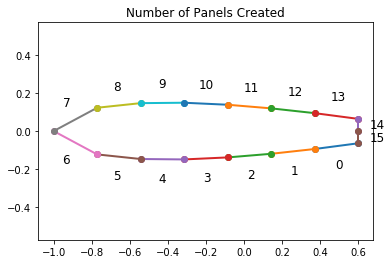

In [4]:
foil,_ = make_trunc(16, 0.2)
foil.plot('o-', 1)
plt.axis('equal')
plt.title('Number of Panels Created')
plt.show()

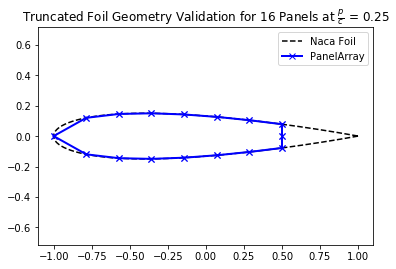

In [5]:
def geom_validation(N, p_c=0.25):
    """
    Overlays the PanelArray plot with a plot of the naca foil section data, to compare number of panels vs shpae
    """
    panels,_ = make_trunc(N, p_c)
    x = np.linspace(0, 1, 1000)
    y = naca_offset(x)
    plt.plot(2*np.append(np.flip(x, 0), x)-1, 2*np.append(-1*np.flip(y, 0), y), 'k--')
    panels.plot(style='bx-')
    plt.title(r'Truncated Foil Geometry Validation for {num} Panels at $\frac{{p}}{{c}}$ = {pc}'.format(num=N, p='p', c='c', pc=p_c))
    plt.legend(['Naca Foil', 'PanelArray'])
    plt.axis('equal')
    plt.show()
    
geom_validation(16)

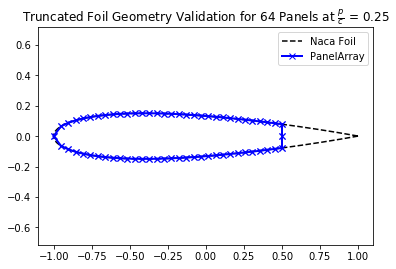

In [6]:
geom_validation(64)

The first plot created shows that the function is correctly producing the right amount of panels, making 16 panels including the panels across the trailing edge. When given an odd number of panels however there will be 1 less panel to make the number of panels even again. The next two plots above show that the geometry is more accurate as the number of panels is increased. 
#### 3.1.2 Kutta Condition
The Kutta condition was decided by plotting the flow and ensuring that it was symmetrical across the foil at zero angle of attack. After testing various Kutta conditions it was decided that the 2nd order solver was not suitable to use for the truncated foil as the panels across the trailing edge are not linearly varying so thethe first order solver is needed due to the fact that it does not assume conitinuity between the panels. The different flows caused by the Kutta conditions are assessed below:

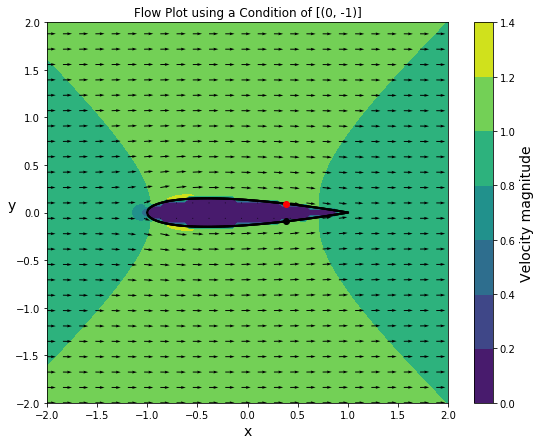

In [7]:
def plot_foil_flow(kutta_condition, p_c=0.25, N=512, alpha=0):
    foil,_ = make_trunc(N, p_c)
    foil.solve_gamma(alpha, kutta=kutta_condition)
    t, b = foil.split()
    topSepX, topSepY = t.sep_point()
    botSepX, botSepY = b.sep_point()
    foil.plot_flow()
    plt.plot(topSepX, topSepY, 'ro')
    plt.plot(botSepX, botSepY, 'ko')
    plt.title('Flow Plot using a Condition of {}'.format(kutta_condition))

plot_foil_flow([(0, -1)], p_c=0)

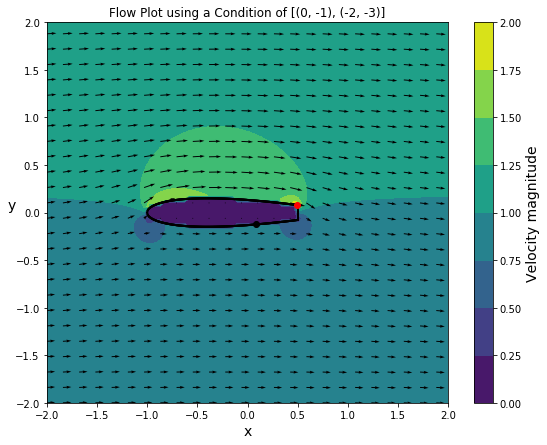

In [8]:
plot_foil_flow([(0, -1), (-2, -3)])

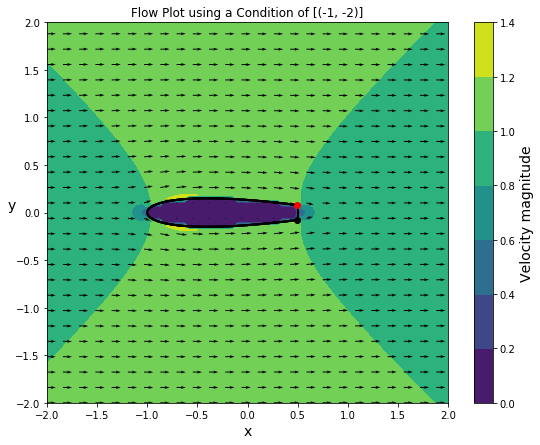

In [9]:
plot_foil_flow([(-1, -2)])

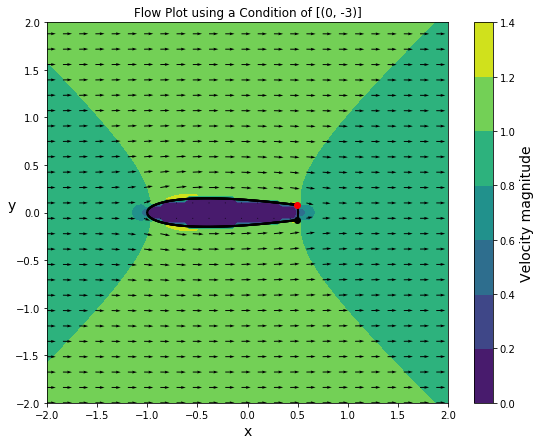

In [10]:
plot_foil_flow([(0, -3)])

The plots above show that when compared to the original foil, the kutta conditions using the trailing edge panels and the last two side panels create the correct symmetrical flow over the foil. The flow plot using the two separate kutta conditions for each corner does not create a symmetrical flow so is not suitable. To decide these two kutta conditions they were tested at an angle of attack:

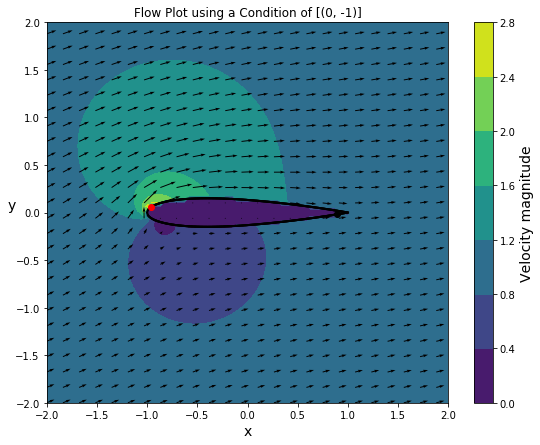

In [11]:
plot_foil_flow([(0, -1)], p_c=0, alpha=0.3)

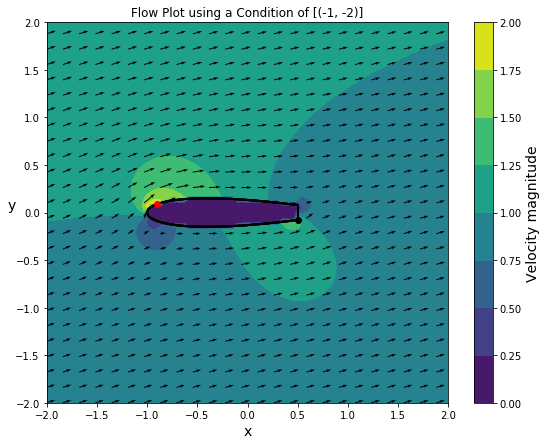

In [12]:
plot_foil_flow([(-1, -2)], alpha=0.3)

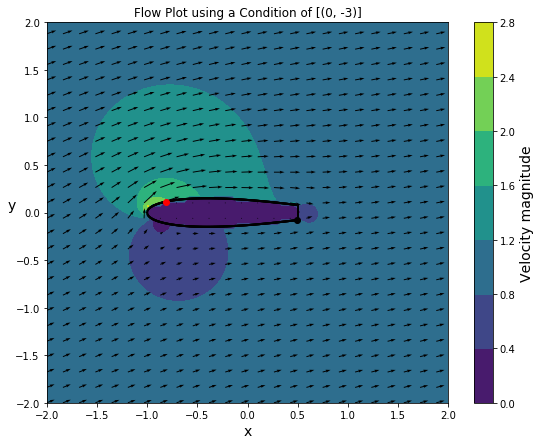

In [13]:
plot_foil_flow([(0, -3)], alpha=0.3)

From the above plots the Kutta condition using the last two panels on the isde of the foil before the cut-off are seen to be the most suitable because when put at an angle of attack, it still has the most similar flow to the complete foil. Whereas the other potential Kutta condition has a much different flow plot to the complete foil, showing that it is not suitable as the flow for the Kammtail foil should be plotted like the complete foil, as Kammtail foil creates a "virtual" tail that means the foil acts as if the complete foil. Therefore a Kutta condition of [(0, -3)] is most suitable, as you can see the lower velocity area more clearly at the trailing edge acting as the "virtual" foil.

### 3.2 Parametric Study

#### 3.2.1 Boundary Layer

The boundary layer calculation code has been validated below by comparing the results produced for an ellipse to the blasius prediction:

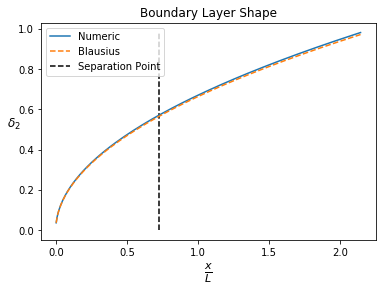

In [14]:
def boundary_layer_plot(panels, kutta_con=0, alpha=0, plot_flow=False, plot_bla=True, returnCoords=False):
    """
    Takes in a PanelArray, panels, and plots the boundary layer distance along the length of the top section
    """
    if kutta_con == 0:
        panels.solve_gamma(alpha)
    else:
        panels.solve_gamma(alpha, kutta=kutta_con)
    top, bot = panels.split()
    topSepX, topSepY = top.sep_point()
    botSepX, botSepY = bot.sep_point()
    s = top.distance()
    delta2, lam, iSep = bl.thwaites(s, np.ones_like(s))
    if returnCoords == True:
        return [s, delta2]
    plt.plot(s, delta2, label='Numeric')
    plt.vlines(topSepX, 0, delta2[-1], 'k', linestyle='--', label='Separation Point')
    if plot_bla == True:
        plt.plot(s, 0.664*np.sqrt(s), label='Blausius', ls='--')
    plt.xlabel(r'$\frac{x}{L}$', size=16)
    plt.ylabel(r'$\delta_2$', size=12, rotation=0)
    plt.legend()
    plt.title('Boundary Layer Shape')
    plt.show()
    if plot_flow == True:
        panels.plot_flow()
        plt.plot(topSepX, topSepY, 'ro')
        plt.plot(botSepX, botSepY, 'ko')
        plt.show()
    
boundary_layer_plot(vp.make_ellipse(256, 0.25))
plt.show()

The plot shows that the boundary layer shpae is a close match to the blasius prediction for an ellipse.

### 3.3 Performance Metrics

#### 3.3.1 Separation Point Validation

In [22]:
@np.vectorize    
def sep(a,pc):
    foil, kutta_con = make_trunc(512, pc)
    foil.solve_gamma(a, kutta=kutta_con)
    
    top,_=foil.split()
    _,_,iSep=top.thwaites()
    x=top.get_array('xc')
    x_c=(x-min(x))/(max(x)-min(x))
    sep=bl.sep(x_c,iSep)
    return sep

Error[%] 0.03828765922757731


Text(0, 0.5, '$\\lambda}$')

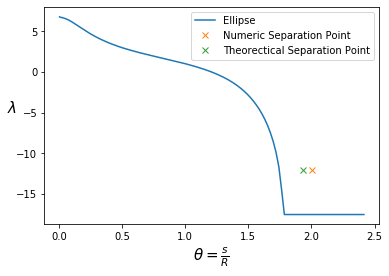

In [25]:
def separation_point(panels, kutta_con=0, alpha=0):
    if kutta_con == 0:
        panels.solve_gamma(alpha)
    else:
        panels.solve_gamma(alpha,kutta_con)
        
    top,_=panels.split()
    _,_,iSep_top=top.thwaites()
    x=top.get_array('xc')
    x_c=(x-min(x))/(max(x)-min(x))
    top_sep=bl.sep(x_c,iSep_top)
    return top_sep

def xc_to_s(x, panels):
    """
    converts a value of xc to distance along the panels
    """
    xc = panels.get_array('xc')
    s = panels.distance()
    for i in range(len(xc)):
        if xc[i] > x:
            interp = inter.interp1d([xc[i-1], xc[i]], [s[i-1], s[i]])
            return interp(x)
    raise ValueError('x is not between 0 and 1')

ellipse = vp.make_ellipse(256, 0.5)

def get_bl(panels, alpha=0):
    panels.solve_gamma(alpha)
    top, bot = panels.split()
    s = top.distance()
    u_s = -top.get_array('gamma')
    delta2, lam, iSep = bl.thwaites(s, u_s)
    sep_dis = bl.sep(s, iSep)
    return lam, s, sep_dis

ellipse_lam, s, sep_dis = get_bl(ellipse)
ellipse_sep_point= separation_point(ellipse)

ellipse.solve_gamma()
top, bot = ellipse.split()
s_sep_point = xc_to_s(ellipse_sep_point, top)

plt.plot(s,ellipse_lam,label='Ellipse')
plt.plot(s_sep_point, -12, 'x', label='Numeric Separation Point')
plt.plot(1.93, -12, 'x', label='Theorectical Separation Point')

print('Error[%]',(s_sep_point-1.93)/1.93)

plt.legend()
plt.xlabel(r'$\theta = \frac{s}{R}$', fontsize=15)
plt.ylabel(r'$\lambda}$', fontsize=15, rotation=0)

the $\theta$ of numerical separation point is higher than that of the theoretical separation point, existing a 3.8% error

#### 3.3.2 Drag

In [ ]:
def trunc_c_gamma(p_c, t_c=0.15, N=256, alpha=0):
    panels, kutta_con = make_trunc(N, p_c, t_c=t_c)
    panels.solve_gamma(alpha, kutta=kutta_con)
    return C_gamma(panels)

In [ ]:
@np.vectorize
def drag(alpha=0, t=0):
    trunc, kutta_con = make_trunc(256,t)
    #trunc.solve_gamma(alpha,kutta_con)
    #trunc.plot_flow()
    C_D=0.14*C_gamma(trunc, kutta_con)
    return C_D

In [ ]:
def C_gamma(panels):
    top,bot=panels.split()
    _,_,iSep=top.thwaites()
    gamma_top=bl.sep(top.get_array('gamma'),iSep)
    w_top=bl.sep(top.get_array('yc'),iSep)
    y=panels.get_array('yc')
    t=max(y)-min(y)
    return 2*w_top/t*gamma_top**2
# Hoerner's data
c_t = np.array([1.27,1.67,2.06,3.06,3.39,4.03,4.73,8.15])
CD = [0.919,0.718,0.604,0.438,0.408,0.342,0.324,0.267]
#plt.scatter(c_t,CD,label='experimental C_D')

@np.vectorize
def ellipse_c_gamma(t_c,N=512):
    panels=vp.make_ellipse(N,t_c)
    panels.solve_gamma_O2()
    return C_gamma(panels)

@np.vectorize
def foil_c_gamma(t_c,N=512):
    foil,kutta_con=make_trunc(512, 0, t_c=t_c)
    foil.solve_gamma(0,kutta_con)
    return C_gamma(foil)

plt.plot(ellipse_c_gamma(1/c_t),CD,'o',label='experimental C_D')
plt.plot(foil_c_gamma(1/c_t,N=512),0.343*foil_c_gamma(1/c_t,N=512),label='full foil C_D')
plt.legend()
plt.xlabel(r'$c_{\gamma}$', fontsize=18)
plt.ylabel(r'$c_D$', fontsize=18);

#### 3.3.3 Lift

In [ ]:
def C_L(panels,alpha):
    gamma, xc, S, sx, sy = panels.get_array('gamma','xc','S','sx','sy')
    c = max(xc)-min(xc)
    perp = sx*np.cos(alpha)+sy*np.sin(alpha)
    return -sum((1-gamma**2)*2*S*perp)/c

In [ ]:
@np.vectorize
def analytic_C_L(alpha, t_c=0.15):
    return 2*np.pi*(1+4/(3*np.sqrt(3))*t_c)*np.sin(alpha)

In [ ]:
@np.vectorize
def numeric_C_L_trunc(alpha, panels, p_c):
    foil,kutta_con = make_trunc(panels, p_c)
    foil.solve_gamma(alpha, kutta=kutta_con)
    gamma, S, xc = foil.get_array('gamma', 'S', 'xc')
    c = max(xc) - min(xc)
    C_L = -sum(gamma*2*S)/(0.5*c)
    return C_L

In [ ]:
def plot_CL():
    plt.plot(np.degrees(np.arange(0, np.pi/8, np.pi/36)), numeric_C_L_trunc(np.arange(0, np.pi/8, np.pi/36), 512, 0), label='numeric 0')
    #plt.plot(np.degrees(np.arange(0, np.pi/8, np.pi/36)), numeric_C_L_trunc(np.arange(0, np.pi/8, np.pi/36), 512, 0.05), label='numeric 0.05')
    #plt.plot(np.degrees(np.arange(0, np.pi/8, np.pi/36)), numeric_C_L_trunc(np.arange(0, np.pi/8, np.pi/36), 512, 0.5), label='numeric 0.5')
   
    plt.plot(np.degrees(np.arange(0, np.pi/8, np.pi/36)), analytic_C_L(np.arange(0, np.pi/8, np.pi/36), 0.15), 'k', linestyle='--', label='analytic')
    plt.xlabel(r'$\alpha$'); plt.ylabel(r'$C_L$', rotation=0);
    plt.legend()

plot_CL()
plt.show()

#### 3.3.4 Added Mass Validation

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in arccos
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in arccos
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in arccos
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in arccos
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in arccos
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in arccos
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in arccos


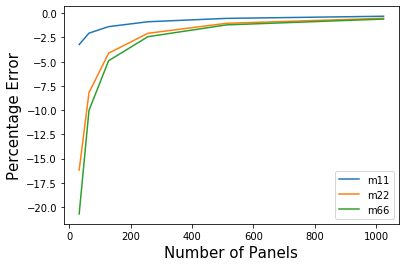

Analytical calculation: 
m11=0.071 
m22=3.142 
m66=0.375
Numerical solution: 
m11= [0.068 0.069 0.07  0.07  0.07  0.07 ] 
m22= [2.633 2.884 3.012 3.077 3.109 3.125] 
m66= [0.298 0.338 0.357 0.366 0.371 0.373]
Error (%): 
m11= [-3.226 -2.051 -1.379 -0.876 -0.527 -0.307] 
m22= [-16.186  -8.195  -4.122  -2.068  -1.036  -0.518] 
m66= [-20.708 -10.019  -4.897  -2.418  -1.201  -0.599]


In [29]:
def ellipse_corners(N,t_c):
    theta = np.linspace(2*np.pi, 0, N+1)
    xs = np.cos(theta)
    ys = t_c*np.sin(theta)
    return xs, ys
 
def added_mass(panels):
    xc, yc, S, sx, sy = panels.get_array('xc','yc','S','sx','sy') # Retrieve gamma, xc, S, sx, sy
    N = len(panels.panels) # Get number of panels used
    A = np.zeros((N, N)) # For storage of the values from the lhs of the equation
    B11 = np.zeros(N) # Arrays for storage of values for the rhs of the equation
    B22 = np.zeros(N)
    B66 = np.zeros(N)
 
    dS = 2*S # length of panel
    n1 = -sy # normal in the x direction
    n2 = sx # normal in the y direction
    n6 = xc * n2 -yc * n1 # from cross product

    x = np.empty(N+1)
    x[0] = xc[0] - S[0]*sx[0]
    x[1:] = xc + S*sx

    y = np.empty(N+1)
    y[0] = yc[0] - S[0]*sx[0]
    y[1:] = yc + S*sy

    for i in range(N):
        r1 = np.linalg.norm(np.array([x[:-1], y[:-1]]).T - np.array([xc[i], yc[i]]), axis=1)
        r2 = np.linalg.norm(np.array([x[1:], y[1:]]).T - np.array([xc[i], yc[i]]), axis=1)
        cos_value = (dS**2 - r2**2 - r1**2)/(-2*r2*r1) 
        theta = -np.arccos(cos_value )
        theta[np.isnan(theta)] = 0

        h11 = (np.log(r1) + np.log(r2))*0.5*dS
        h22 = (np.log(r1) + np.log(r2))*0.5*dS
        h66 = (np.log(r1) + np.log(r2))*0.5*dS

        A[i] = theta
        np.fill_diagonal(A, -np.pi)

        B11[i] = sum(n1*h11)
        B22[i] = sum(n2*h22)
        B66[i] = sum(n6*h66)

    phi11 = np.linalg.solve(A, B11)
    phi22 = np.linalg.solve(A, B22)
    phi66 = np.linalg.solve(A, B66)

    m11 = sum(phi11*n1*dS)
    m22 = sum(phi22*n2*dS)
    m66 = sum(phi66*n6*dS)
 
    return m11, m22, m66
 
@np.vectorize
def ellipse_added_mass(N, t_c):
    ellipse = vp.make_ellipse(N, t_c)
    ellipse.solve_gamma(alpha=0.0) #solving for vorticity strength
    ellipse.plot_flow(size=2) #plotting for visual check
    plt.close()

    m11_exact = np.pi*t_c**2
    m22_exact = np.pi
    m66_exact = 1/8 * np.pi * (1 - t_c**2)**2

    m11, m22, m66 = added_mass(ellipse)

    m11_error = (m11/m11_exact-1)*100
    m22_error = (m22/m22_exact-1)*100
    m66_error = (m66/m66_exact-1)*100
 
    return m11_exact, m22_exact, m66_exact, m11, m22, m66, m11_error, m22_error, m66_error
 
@np.vectorize
def trunc_added_mass(N, p_c):
 
    panels,kutta_con = make_trunc(N, p_c)
    panels.solve_gamma(alpha=0,kutta=kutta_con) #solving for vorticity strength
    panels.plot_flow(size=2) #plotting for visual check
    plt.close()
 
    m11, m22, m66 = added_mass(panels)
 
    return m11, m22, m66
 
numPanel = [2**i for i in np.arange(5, 11)]
m11_exact, m22_exact, m66_exact, m11, m22, m66, m11_error, m22_error, m66_error = ellipse_added_mass(numPanel, 0.15)
 
plt.plot(numPanel, m11_error, label='m11')
plt.plot(numPanel, m22_error, label='m22')
plt.plot(numPanel, m66_error, label='m66')
plt.xlabel('Number of Panels',fontsize=15)
plt.ylabel('Percentage Error',fontsize=15)
plt.legend()
plt.show()
print('Analytical calculation:',
      '\nm11={:.3f}'.format(m11_exact[0]),
      '\nm22={:.3f}'.format(m22_exact[0]),'\nm66={:.3f}'.format(m66_exact[0]))
for i in range(0,6):
    m11[i]='{:.3f}'.format(m11[i])
    m22[i]='{:.3f}'.format(m22[i])
    m66[i]='{:.3f}'.format(m66[i])
print('Numerical solution:','\nm11=',m11,'\nm22=',m22,'\nm66=',m66)
for i in range(0,6):
    m11_error[i]='{:.3f}'.format(m11_error[i])
    m22_error[i]='{:.3f}'.format(m22_error[i])
    m66_error[i]='{:.3f}'.format(m66_error[i])
print('Error (%):','\nm11=',m11_error,'\nm22=',m22_error,'\nm66=',m66_error)
  

## 4. Results

### 4.1 Changes in Drag Coefficient for Varying values of p/c

In [58]:
def C_gamma(panels, kutta_con):#:
    panels.solve_gamma(0, kutta=kutta_con)
    top,bot=panels.split()
    xTop, yTop = top.sep_point()
    xBot, yBot = bot.sep_point()
    _,_,iSepTop = top.thwaites()
    _,_,iSepBot = bot.thwaites()
    gamma_top = bl.sep(top.get_array('gamma'), iSepTop)
    gamma_bot = bl.sep(bot.get_array('gamma'), iSepBot)
    w = yTop - yBot
    y = panels.get_array('yc')
    return w*(np.mean([gamma_top**2, gamma_bot**2]))/(max(y)-min(y))

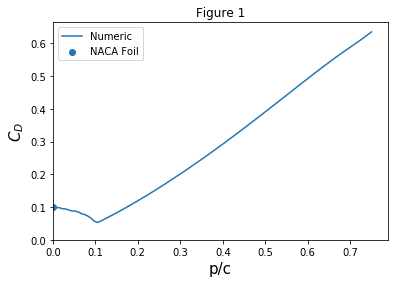

In [72]:
pc = np.linspace(0, 0.75, 100)
C_D = drag(t=pc)
plt.plot(pc, C_D, label='Numeric')
plt.scatter(0, 0.1, label = 'NACA Foil')
#plt.scatter(0.7, 0.41, label='Semi circle')
plt.xlim(0, )
plt.ylim(0, )
plt.xlabel('p/c',fontsize=15)
plt.ylabel(r'$C_D$',fontsize=15)
plt.title(r'Figure 1')
plt.legend()
plt.show()

#trunc, kutta_con = make_trunc(512, 0.05)
#trunc.solve_gamma(0, kutta=kutta_con)
#trunc.plot_flow()
#trunc, kutta_con = make_trunc(512, 0.075)
#trunc.solve_gamma(0, kutta=kutta_con)
#trunc.plot_flow()
#plt.show()

### 4.2 Changes in Separation Points for Varying values of p/c

In [30]:
def separation_point(panels, kutta_con, alpha=0):
    panels.solve_gamma(alpha,kutta_con)
    top,bot=panels.split()
    _,_,iSep_top=top.thwaites()
    _,_,iSep_bot=bot.thwaites()
    x=top.get_array('xc')
    y=bot.get_array('xc')
    x_c=(x-min(x))/(max(x)-min(x))
    y_c=(y-min(y))/(max(y)-min(y))
    top_sepx=bl.sep(x, iSep_top)
    top_sepy=bl.sep(y, iSep_top)
    top_sep=bl.sep(x_c,iSep_top)
#    print(t)
#    print(top_sepx, top_sepy)
#    print(top_sep)
    bot_sep=bl.sep(y_c,iSep_bot)
#    print(bot_sep)
    return top_sep,bot_sep

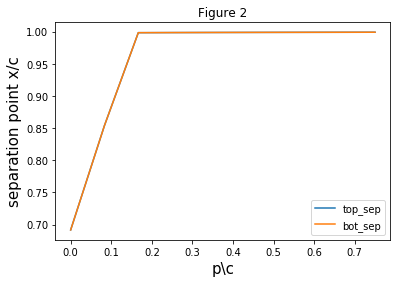

In [31]:
t=np.linspace(0,75,10)
top = []; bot = []
for i in t:
    nfoil, kutta_con = make_trunc(1024,i/100)
    topSep, botSep = separation_point(nfoil, kutta_con)
    top.append(topSep)
    bot.append(botSep)
plt.plot(t/100,top,label='top_sep')
plt.plot(t/100,bot,label='bot_sep')
plt.legend()
plt.xlabel(r'p\c', fontsize=15)
plt.ylabel(r'separation point x/c', fontsize=15);
plt.title(r'Figure 2')
plt.show()

### 4.3 Change in Lift Coefficient for Varying values of p/c

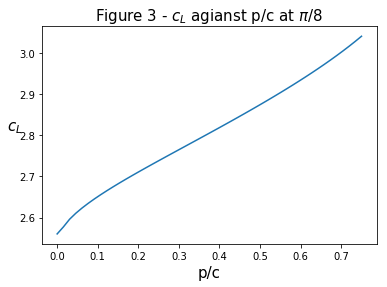

In [69]:
@np.vectorize
def numtrunc_C_L(t):
    foil, kutta_con = make_trunc(512, t)
    foil.solve_gamma(np.pi/8, kutta=kutta_con)
    gamma,S,xc=foil.get_array('gamma','S','xc')
    c=max(xc)-min(xc)
    C_L = -sum(gamma*2*S)/(0.5*c)
    return C_L

t=np.linspace(0,0.75,50)
plt.plot(t,numtrunc_C_L(t))
plt.title('Figure 3 - $c_L$ agianst p/c at $\pi/8$ ',fontsize=15)
plt.xlabel(r'p/c', fontsize=15)
plt.ylabel(r'$c_L$', fontsize=15, rotation=0)
plt.show()

### 4.4 Change in Added Mass for Varying values of p/c

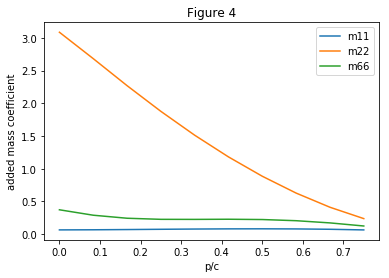

In [67]:
pc = np.linspace(0, 0.75, 10)
m11_trunc, m22_trunc, m66_trunc = trunc_added_mass(1024, pc)
 
plt.plot(pc, m11_trunc, label='m11')
plt.plot(pc, m22_trunc, label='m22')
plt.plot(pc, m66_trunc, label='m66')
plt.xlabel('p/c')
plt.ylabel('added mass coefficient')
plt.title(r'Figure 4')
plt.legend()
plt.show()

## Changes in Boundary Layer Size for Varying Values of $\frac{p}{c}$

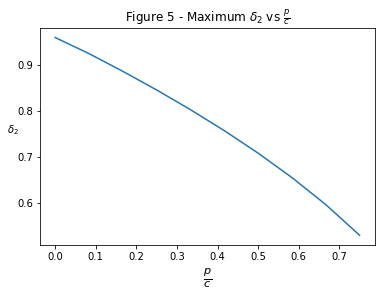

In [66]:
pvc = np.linspace(0, 0.75, 10)
max_bd = []; max_s = []
for i in pvc:
    panels, kutta = make_trunc(256, i)
    _,bd = boundary_layer_plot(panels, kutta_con=kutta, returnCoords=True)
    max_bd.append(np.amax(np.array(bd)))

plt.plot(pvc, max_bd, label=r'$Max \delta_2$')
plt.xlabel(r'$\frac{p}{c}$', size=16)
plt.ylabel(r'$\delta_2$', rotation=0)
plt.title(r'Figure 5 - Maximum $\delta_2$ vs $\frac{p}{c}$')
plt.show()

## 5.Discussion



#### 5.1.Drag plot –

Figure 1 illustrates how the Coefficient of drag changes with the p/c ratio. As mentioned in the methodology section, a constant had to be found to relate Cd and C gamma. This was done throught the use of data from Hoerner. Mainly, a symmetric NACA foil (NACA-64-015 and NACA-65-015). Unfortunately, since this study is primarily concerned with the performance of the foil at $\alpha = 0$, it was not possible to use more than the one data point. It also proved impossible to validate at the far side where p/c approaches 0.75. Initially it was thought that a half circle could be used but this would not work as the shapes are too different.

The drag coefficient initially experiences a steady decrease, reaching a minimum at $\frac{p}{c} = 0.1$. This minimum suggests that the kamm-tail foil can indeed be optimized to operate at a minimum drag. AUVs could be designed with this data for optimal efficiency. The data could also be used to illustrate the tradeoff in efficiency for an improved storage solution.


#### 5.2.Separation plot -

Figure 2 shows how the separation distance (distance from the front of the foil to the truncated edge(c-p)) varies as the foil is increasingly truncated. The figure shows an initial ratio of 0.7 which increases constantly to reach 1 at a p/c value of $\approx0.15$. After this the separation point position is equal to the point of truncation. 

This supports the results from the previously discussed section. The steady increase shows the point of separation moves further back along hte foil as the tail is truncated. this would lead to less turbulent flow along the foil, resulting in less resistance. There would be an optimim efficiency as there would be an increase in turbulent flow along the trailing edge.


#### 5.3.Lift plot -

As mentioned in section 5.1. this study is primarily concerned with the foil operating in the $\alpha = 0$ condition. In this case the figure does show the foil operating in $\alpha = \frac{\pi }{8}$ for better comparison. It can be seen that as the $\frac{p}{c}$ ratio increases, so does the lift generated. This is similar to the figure discussed in section 5.1 with the only difference being the lack of an optimal value. Or of the optimal value being at $\frac{p}{c} = 0.75$. This is undesirable as the for design purposes as the primary concern is drag and would therefore not be optimized for lift.

The steady increase will be due to the increase in pressure at the trailing edge, leading to shigting pressure around the leading edge. This will lead to a larger net difference in pressure between the two sided and therefore more lift.

#### 5.4.Added Mass plot -

Figure 4 shows that the added mass doesn’t change in the m11 and m66 direction, or experiences only minor changes. This is primarily due to the nature of this study. In this study the change is truncating the foil, which will logically only affect the added mass in one direction.

The added mass coefficients are all at their lowest at $\frac{p}{c} = 0.75$. The m22 value then steadily increases reaching a maximum at $\frac{p}{c} = 0$ of 3.



#### 5.5. Boundary Layer plot -

Figure 5 shows the boundary layer thickness varies with $\frac{p}{c}$. Thge plot illustrates a steady decrease in the boundary layer thickness as the $\frac{p}{c}$ ratio increases. This too is logical as the boundary layer will have less time to develop along the length of the foil.

## Conclusion

In conclusion, This study has carried out an investigation into the effects of truncating foils. This has bee done in an effort to aid in the development of AUVs in terms of optimizing them for storage and improved performance. The majour findings of this study include an optial $\frac{p}{c}$ ratio of 0.1 which reduces drag. This will lead to improved performance while making it easier to store. One of the added benefits included no loss of effective are of the AUV. This is because the small section which is truncated is narrow and of little use for storage of equipment.
